In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import pydotplus
from subprocess import check_call
from graphviz_sql.extract import to_sql 
import seaborn as sns
from imblearn.over_sampling import SMOTE
import sqlite3
import pickle
from scipy import stats
import sys
import argparse
import os
import time
import itertools


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')   
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# 定义检测函数
from scipy.stats import ks_2samp
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
    is_drift = any([result["drift"] for result in results])   

    # 返回结果列表
    return is_drift

In [5]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00345:
        is_drift_mmd=True
    return is_drift_mmd

In [6]:
####  H-D
join=os.path.join
from sklearn.decomposition import PCA
# parser = argparse.ArgumentParser()

# parser.add_argument('--n', type=int, default=300)
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--log_dir', type=str, default='logs')
# parser.add_argument('--runs', type=int, default=1)

n=500
seed=1
log_dir='logs'
runs=1
bandwidth = 'scott'
max_data_size = n
# args = parser.parse_args()
#scott

np.random.seed(seed)

def get_kde_estimates(bandwidth, data) :
	# kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
	data = data.T
	kernel = stats.gaussian_kde(data, bandwidth)
	return kernel.evaluate(data)




if not os.path.exists(log_dir):
	os.makedirs(log_dir)




# dataX=df_budapest.drop(columns=["BBQ_weather","DATE","MONTH"])
# dataY=df_oslo.drop(columns=["BBQ_weather","DATE","MONTH"])
# dataX = dataX.reset_index(drop=True)
# dataY = dataY.reset_index(drop=True)
# dataX = dataX.to_numpy()
# dataY = dataY.to_numpy()




fname = join(log_dir, 'result_' + str(max_data_size) + '.txt')

def in_top_k(scores, k):
    indices = np.argsort(scores)[::-1]
    pos = np.where(indices==0)[0][0]
    return pos <= k

def evaluate(data_1,data_2):
    scores = []
    data1 = data_1.sample(n=300, replace=False, random_state=42).to_numpy()
    data2 = data_2.to_numpy()
  
    for rep in range(100):

        if rep != 0:
            data_all = np.concatenate([data1, data2], axis=0)
            data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
            data1 = data_all[:max_data_size]
            data2 = data_all[max_data_size:]
        datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)
        pca = PCA(n_components=5)

        # 将13维数组X降维到5维
        data1 = pca.fit_transform(data1)
        data2 = pca.fit_transform(data2)
        datam = pca.fit_transform(datam)
        logprob_1 = get_kde_estimates(bandwidth, data1)
        logprob_2 = get_kde_estimates(bandwidth, data2)
        logprob_m = get_kde_estimates(bandwidth, datam)

        vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
        with open(fname, 'a') as f:
            f.write("Scores " + str(np.mean(logprob_1)) + " " + str(np.mean(logprob_2)) + " " + str(np.mean(logprob_m)) + "\n")
        scores.append(vdiv)

    return in_top_k(scores, k=5)



In [3]:
def find_distributions(model, data):
    X_test = data[['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
       'occupation', 'relationship', 'capital_gain', 'capital_loss',
       'hours_week', 'country', 'race', 'sex','marital']]
    y_test = data[["income"]]
    y_predict = model.predict(X_test)
    y_predict = (y_predict > 0.5).astype(int)
    y_test_DT = y_test.reset_index()
    y_predict_DT = pd.DataFrame(y_predict, columns = ['predict'])
    data_M2 = pd.concat([y_test_DT, y_predict_DT], axis=1, join='inner')
    data_M2['result'] = np.where(data_M2["income"]==data_M2['predict'],'0','1')
    data_M2.set_index(["index"], inplace=True)
    data_M2 = pd.concat([data_M2, X_test], axis=1, join='inner')
    
    x_DT = data_M2[['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'occupation', 'relationship', 'capital_gain', 'capital_loss',
       'hours_week', 'country', 'race', 'sex', 'marital']]
    y_DT = data_M2[["result"]]
    X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(x_DT, y_DT, test_size=0.5, random_state=42)
    
    # ### SMOTE
    # y_train_DT = y_train_DT.astype('int')
    # oversample = SMOTE(random_state=42, k_neighbors=2)
    # X_balance_DT,Y_balance_DT = oversample.fit_resample(X_train_DT,y_train_DT)
    # X_balance_DT = pd.DataFrame(X_balance_DT, columns = X_train_DT.columns)
    
    #train Decision tree
    # method 1
#     model_DT = DecisionTreeClassifier(max_depth=8,
                             
#                                       random_state=42
#                                )

    from sklearn.model_selection import GridSearchCV

    # Define the parameter grid for 'max_depth' and 'min_samples_leaf'
    param_grid = {
        'max_depth': range(3, 11),  # Testing max_depth values from 3 to 10
        'min_samples_leaf': [int(x) for x in np.linspace(start=0.01 * len(X_train_DT), stop=0.05 * len(X_train_DT), num=5)]  # 1% to 5% of the dataset
    }

    # Create the Decision Tree model
    model_DT_ori = DecisionTreeClassifier(random_state=42)

    # Set up GridSearchCV with 10-fold cross-validation
    grid_search = GridSearchCV(estimator=model_DT_ori, param_grid=param_grid, cv=10, scoring='accuracy')

    # Fit the grid search to the data (assuming X and y are your features and target variable)
    grid_search.fit(X_train_DT, y_train_DT)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Create a new model with the best parameters
    model_DT = DecisionTreeClassifier(**best_params, random_state=42)

    # Train the optimized model


    model_DT.fit(X_train_DT, y_train_DT)
    y_test_DT = y_test_DT.astype('int')
    y_predict_DT = model_DT.predict(X_test_DT)
    
    ##save DT tree plan dot
    dot_data=tree.export_graphviz(model_DT, out_file='./image/tree_DT_Interpretable_pipeline_test.dot', feature_names= x_DT.columns,
                               class_names=['0', '1'], node_ids=True,
                              filled=True, rounded=True,  
                              special_characters=True)
    check_call(['dot','-Tpng','./image/tree_DT_Interpretable_pipeline_test.dot','-o','./image/tree_DT_Interpretable_CatBoost_3.png'])
    ##save sql doc
    to_sql('./image/tree_DT_Interpretable_pipeline_test.dot', './image/tree_DT_Interpretable_pipeline_test.sql')
    
    X_test['predict'] = y_predict
    X_test['result'] = np.where(y_test['income']==X_test['predict'],'0','1')
    data_result = X_test
    data_result['team'] = 0
    df = data_result
    #connect to a database
    conn = sqlite3.connect("pipleine_ourM3.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
    #store your table in the database:
    df.to_sql('Some_Table_Name', conn)
    #read a SQL Query out of your database and into a pandas dataframe
    sql_string = 'SELECT * FROM Some_Table_Name'
    df = pd.read_sql(sql_string, conn)
    # Open and read the file as a single buffer
    fd = open('./image/tree_DT_Interpretable_pipeline_test.sql', 'r')
    sqlFile = fd.read()
    fd.close()
    ## prepare sql document
    sqlFile=sqlFile.replace('select case', 'UPDATE Some_Table_Name \nSET team = \nCASE')
    n=sqlFile.count('then 0 ')

    sqlFile = sqlFile.replace('then 0 ', 'then -xxx')
    for i in range(n):
        sqlFile = sqlFile.replace('-xxx', str(-i), 1)

    m=sqlFile.count('then 1 ')
    sqlFile = sqlFile.replace('then 1 ', 'then +xxx')
    for i in range(m):
        sqlFile = sqlFile.replace('+xxx', str(i+1), 1)
    fd = open('./image/tree_DT_Interpretable_pipeline_test.sql', 'w+')
    fd.write(sqlFile)
    fd.close()

    ## compile sql doc
    sql_string = sqlFile.split(';')
    cur = conn.cursor()
    for command in sql_string:
        cur.execute(command)
    os.remove("pipleine_ourM3.db")
    ##read data from database
    sql_string='SELECT * FROM Some_Table_Name;'
    df = pd.read_sql(sql_string, conn)
    df1= df.team.value_counts()
    df1.to_csv("./data/Black_box_team_count_pepiline.csv")    
    g = df.groupby("team")
    m=g['result'].value_counts(normalize=True,sort=False)
    acc=m.loc[-400:400,'0']
    acc=acc.to_frame()
    acc.to_csv("./data/Black_box_acc_result_pipeline.csv")    
    df1=pd.read_csv("./data/Black_box_team_count_pepiline.csv")
    df1.set_index(["Unnamed: 0"], inplace=True)
    df1 = df1.rename_axis('Team_number')
    df1 = df1.rename(columns={'team': 'account'})
    acc = pd.read_csv("./data/Black_box_acc_result_pipeline.csv")
    acc=acc[['team','result.1']]
    acc.set_index(["team"], inplace=True)
    acc = acc.rename_axis('Team_number')
    acc = acc.rename(columns={'result.1': 'Accuracy'})
    List_accuracy = pd.concat([acc, df1], axis=1, join='inner')
    accuracy_team=List_accuracy.reset_index()
    
    #low_accuracy_teams=low_accuracy_teams.reset_index() 
    accuracy_team['percentage']= accuracy_team['account']/X_test['age'].count()
    #low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < 0.93959]
#     X = low_accuracy_teams['Team_number']
#     y = low_accuracy_teams['percentage']

#     # 创建柱状图
#     plt.bar(X, y)

#     # 设置 X 轴和 Y 轴标签
            

#     # 显示图形
#     plt.show()

    return accuracy_team
    


In [4]:
def low_acc_sample(model, x_data, y_data):
    y_predict_data = model.predict(x_data)
    y_data = y_data.reset_index()
    y_predict_data = pd.DataFrame(y_predict_data, columns = ['predict'])

    data_result = pd.concat([y_data, y_predict_data], axis=1, join='inner')
    data_result['result'] = np.where(data_result['income']==data_result['predict'],'0','1')
    data_result.set_index(["index"], inplace=True)
    data_result = pd.concat([data_result, x_data], axis=1, join='inner')
    # data_result_0 = data_result[data_result['result'] == "0"]
    # data_result_0 = data_result_0.sample(frac=0.05, random_state=42)
    if len(data_result[data_result['result'] == "1"])>150:
        data_result_1 = data_result[data_result['result'] == "1"].head(150)
    else:
        data_result_1 = data_result[data_result['result'] == "1"]
    n= 300-len(data_result_1)    
    data_result_0 = data_result[data_result['result'] == "0"]
    data_result_0 = data_result_0.head(n)
    data_result = pd.concat([data_result_0, data_result_1], axis=0)
    data_result = data_result.sample(frac=1, random_state=42)
    x_data = data_result.drop(columns=["income","predict","result"])
    y_data = data_result['income']

    y_predict_data = model.predict(x_data)
    #print(' Accuracy Score is {:.5}'.format(accuracy_score(y_data, y_predict_data)))
    # print(pd.DataFrame(confusion_matrix(y_data,y_predict_data)))

    data_result=data_result.drop(columns=["predict","result"])
    return data_result

In [8]:
# 读取数据集到dataframe
df_all = pd.read_csv("../dataset/adult.csv")
#df_all = df_all[["type","amount","oldbalanceOrg","newbalanceOrig","isFraud"]]
#df_oslo = pd.read_csv('/Users/sdong/phd_doc/att/weather_data/oslo_data.csv')
df_all = df_all.rename(columns={
    'age': 'age',
    'workclass': 'workclass',
    'fnlwgt': 'fnlwgt',
    'education': 'education',
    'education.num': 'education_num',
    'marital.status': 'marital',
    'occupation': 'occupation',
    'relationship': 'relationship',
    'capital.gain': 'capital_gain',
    'capital.loss': 'capital_loss',
    'hours.per.week': 'hours_week',
    'native.country': 'country',
    'income': 'income',
    'race': 'race',
    'sex': 'sex'
})
df_all[df_all == '?'] = np.nan
for col in ['workclass', 'occupation', 'country']:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)
df_all.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [9]:
df_all.marital.value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital, dtype: int64

In [10]:

# 将 income 列的值替换为布尔值
income_bool = df_all['income'].replace({'<=50K': False, '>50K': True})

# 将 income_bool 列添加回原始 DataFrame 中
df_all['income'] = income_bool

# 打印替换后的结果
#print(df[['adult.income', 'income_bool']].head())

In [11]:
df_all.to_csv("../dataset/adult_prepare.csv", index=False)

In [12]:
df_all.head()
# df_all.race.value_counts()
# df_all.sex.value_counts()


,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,False
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,False
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,False
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,False
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,False


In [13]:
from sklearn import preprocessing

categorical = ['workclass', 'education', 'occupation', 'relationship', 'country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        df_all[feature] = le.fit_transform(df_all[feature])
        
#print(df_all)        
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 假设标签列为 'label'
income = df_all[['income','race', 'sex','marital']]
data = df_all.drop(columns=['income','race', 'sex','marital'], axis=1)

df_all = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

# 将标签列合并回去
df_all_std = pd.concat([df_all, income], axis=1)
df_all_std['race']=df_all_std['race'].replace({'White': 1, 'Black': 2, 'Asian-Pac-Islander': 3, 'Amer-Indian-Eskimo': 4, 'Other': 5})
df_all_std['sex']=df_all_std['sex'].replace({'Male': 6, 'Female': 7})
df_all_std['marital']=df_all_std['marital'].replace({'Married-civ-spouse': 8, 'Never-married': 9, 'Divorced': 10, 'Separated': 11, 'Widowed': 12, 'Married-spouse-absent': 13,'Married-AF-spouse': 14})
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
df_all_std.head()
df_all_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            32561 non-null  float64
 1   workclass      32561 non-null  float64
 2   fnlwgt         32561 non-null  float64
 3   education      32561 non-null  float64
 4   education_num  32561 non-null  float64
 5   occupation     32561 non-null  float64
 6   relationship   32561 non-null  float64
 7   capital_gain   32561 non-null  float64
 8   capital_loss   32561 non-null  float64
 9   hours_week     32561 non-null  float64
 10  country        32561 non-null  float64
 11  income         32561 non-null  bool   
 12  race           32561 non-null  int64  
 13  sex            32561 non-null  int64  
 14  marital        32561 non-null  int64  
dtypes: bool(1), float64(11), int64(3)
memory usage: 3.5 MB


## 循环training model 测试

Epoch 1/10
102/102 [==============================] - 1s 3ms/step - loss: 0.3829 - accuracy: 0.8394 - val_loss: 0.3215 - val_accuracy: 0.8547
Epoch 2/10
102/102 [==============================] - 0s 3ms/step - loss: 0.2979 - accuracy: 0.8701 - val_loss: 0.2887 - val_accuracy: 0.8673
Epoch 3/10
102/102 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.8756 - val_loss: 0.2814 - val_accuracy: 0.8762
Epoch 4/10
102/102 [==============================] - 0s 3ms/step - loss: 0.2629 - accuracy: 0.8836 - val_loss: 0.2838 - val_accuracy: 0.8689
Epoch 5/10
102/102 [==============================] - 0s 3ms/step - loss: 0.2530 - accuracy: 0.8876 - val_loss: 0.2805 - val_accuracy: 0.8725
Epoch 6/10
102/102 [==============================] - 0s 3ms/step - loss: 0.2484 - accuracy: 0.8891 - val_loss: 0.2725 - val_accuracy: 0.8787
Epoch 7/10
102/102 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.8897 - val_loss: 0.2706 - val_accuracy: 0.8759
Epoch 

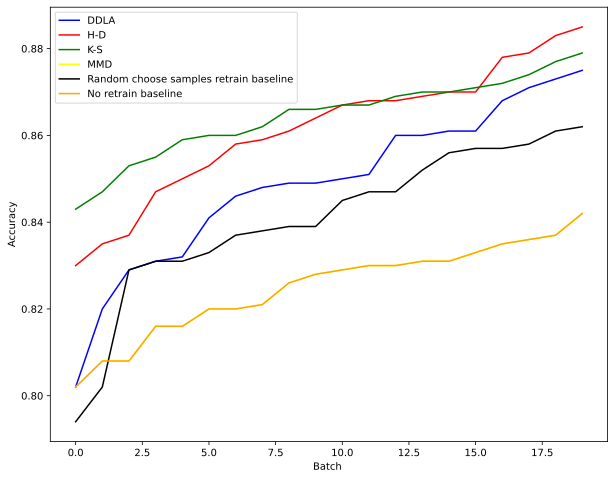

Average Oue methods: 0.8488499999999999
Average KS: 0.8643499999999997
Average MMD: 0.82495
Average HD: 0.8615499999999997
Average no retrain: 0.82495
Average ramdom choose retrain: 0.8407500000000001
The number our retrained accuracy highter than random: 12


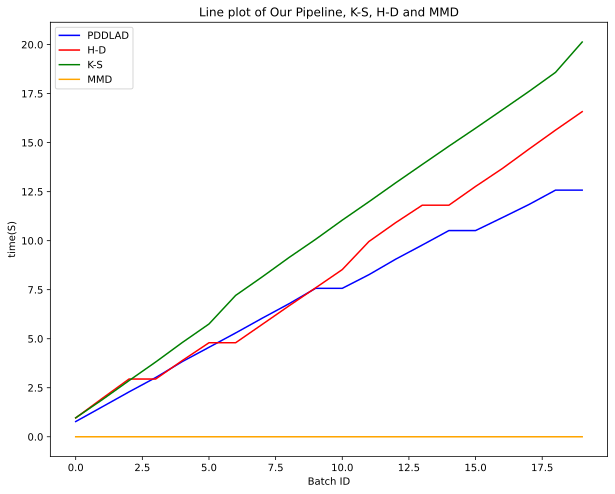

PDDLA retraining time: 12.577847003936768
KS retraining time: 20.12995433807373
MMD retraining time: 0
HD retraining time: 16.579193115234375
20


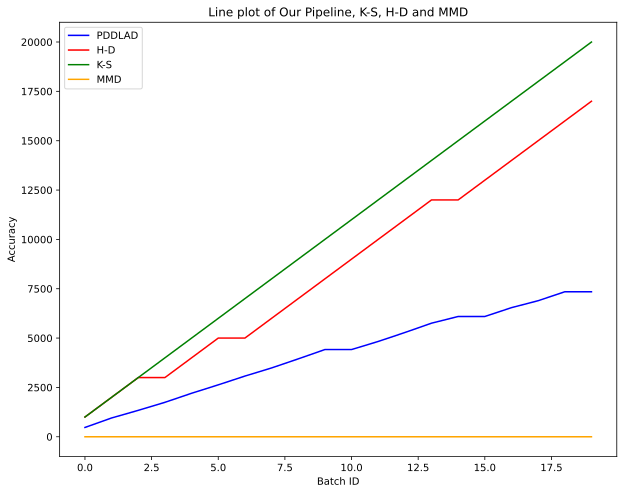

PDDLA the number that expert labeled: 7347
KS the number that expert labeled: 20000
HD the number that expert labeled: 17000
MMD the number that expert labeled: 0


In [18]:
batch_size = 1000
sorted_data = df_all_std.sort_values(by=['race', 'sex'])

PDDLA_Increase_list = []
is_drift_mmd_list = []
is_drift_hd_list=[]
is_drift_KS_list = []

Number_AL=[]
Number_AL_KS=[]
Number_AL_MMD=[]
Number_AL_HD=[]

accuracy_sample_list = []
accuracy_sample_list_DDLA = []
accuracy_sample_list_MMD = []
accuracy_sample_list_HD = []
accuracy_sample_list_KS = []
accuracy_sample_list_random =[]


accuracy_sample_high_count=0

PDDLA_Increase_count = 0
count_retrain_KS = 0
count_retrain_MMD = 0
count_retrain_HD = 0

trainingtime_list_DDLA = []
trainingtime_list_KS = []
trainingtime_list_MMD = []
trainingtime_list_HD = []

for i in range(20):
    # total_rows = len(sorted_data)
    # top_5_percent_index = int(0.05 * total_rows)
    # train_set = sorted_data.head(top_5_percent_index)
    
    # 计算要保留的数据数量
    keep_count = int(len(sorted_data) * 0.5)

    # 使用切片操作获取后面百分之五十的数据
    result = sorted_data[-keep_count:]
    

    train_set = result.sample(frac=0.4)
    test_set = sorted_data.drop(train_set.index)
    test_set_1 = result.drop(train_set.index)
    # 查看 adult.income 列的值计数
    income_counts = train_set['income'].value_counts()

    # 打印值计数
    # print(income_counts)
    
    x = train_set.drop(columns=["income"])
    y = train_set[["income"]]

    # splitting the data
    X_train_ML, X_test_ML, y_train_ML, y_test_ML = train_test_split(x, y, test_size=0.5, random_state=42)

    # from imblearn.over_sampling import SMOTE
    # y_train_ML = y_train_ML.astype('int')
    # oversample = SMOTE(random_state=42)
    # X_balance_ML,Y_balance_ML = oversample.fit_resample(X_train_ML,y_train_ML)
    # X_balance_ML = pd.DataFrame(X_balance_ML, columns = X_train_ML.columns)
    
    ### training the black box model 
    
    ###### LightGBM
    # model = LGBMClassifier(num_leaves=31,
    #                        max_depth=8, 
    #                        learning_rate=0.02,
    #                        n_estimators=250,
    #                        subsample = 0.8,
    #                        colsample_bytree =0.8
    #                       )

    # model = RandomForestClassifier(n_estimators=250,
    #                               max_depth=12,
    #                               min_samples_leaf=16
    #                               )

    # #######
    # model = XGBClassifier(max_depth=12,
    #                       n_estimators=250,
    #                       min_child_weight=8, 
    #                       subsample=0.8, 
    #                       learning_rate =0.02,    
    #                       seed=42)
    
    
    
    #####################
    from keras.models import Sequential
    from keras.layers import Dense

    # 构建神经网络模型
    model = Sequential()
    # model.add(Dense(64, activation='relu', input_dim=14))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    
    # model.add(Dense(32, activation='relu', input_dim=14))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    
    model.add(Dense(128, activation='relu', input_dim=14))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # 编译模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    # 训练模型
    model.fit(X_train_ML, y_train_ML, epochs=10, validation_data=(X_test_ML, y_test_ML))





    
    ############


    #model.fit(X_balance_ML, Y_balance_ML)
    # 记录结束时间

    y_predict = model.predict(X_test_ML)
    y_predict = (y_predict > 0.5).astype(int)
    acc_tre = accuracy_score(y_test_ML, y_predict)

    #acc_tre = accuracy_score(y_test_ML, y_predict)
    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_ML, y_predict)))
    print(pd.DataFrame(confusion_matrix(y_test_ML,y_predict)))
    
    filename = "./model/model_LR_test_fraud.joblib"
    joblib.dump(model, filename)
    
    
    #########################################################################
    ############ our Method ##################
    
    data_test = pd.concat([X_test_ML, y_test_ML], axis=1, join='inner')
    #data_test.info()
    accuracy_team = find_distributions(model, data_test)
    # print(accuracy_team)

    model = joblib.load("./model/model_LR_test_fraud.joblib")
    
    drift_samples_df_1= test_set

    drift_samples_df= train_set
    new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')
    
    
    # if i % 2 == 1:

        ### random sampling without replacement

#     sample = drift_samples_df_1.sample(batch_size,  replace=True, random_state=42)
    
    
    
#     # else: 
#     #     sample = test_set_1.sample(batch_size,  replace=True, random_state=42)
    
    
#     y_predict_sample = model.predict(sample.drop(columns=["income"]))
#     y_sample = sample[["income"]]
#     y_predict_sample = (y_predict_sample > 0.5).astype(int)
#     accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    while True:
        sample = drift_samples_df_1.sample(batch_size, replace=False)
        y_predict_sample = model.predict(sample.drop(columns=["income"]))
        y_sample = sample[["income"]]
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)

        if accuracy_sample < 0.85:
            break

   
    
    #########################################################################
    ## k-s test result
    is_drift_KS = drift_detection(train_set.drop(columns=["income"]), sample.drop(columns=["income"]))
    is_drift_KS_list.append(is_drift_KS)
    
    ## MMD test result
    sigma = 1
    is_drift_mmd = mmd_fast(train_set.drop(columns=["income"]), sample.drop(columns=["income"]))
    is_drift_mmd_list.append(is_drift_mmd)

    # H-D test result
    # 检测数据分布是否漂移
    is_drift_hd = evaluate(train_set.drop(columns=["income"]), sample.drop(columns=["income"]))
    is_drift_hd_list.append(is_drift_hd)
    
    

    sample["team"] =  0
    df = sample 
    Number_AL.append(0)
    
    #connect to a database
    conn = sqlite3.connect("sample_pipeline5.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
    #store your table in the database:
    df.to_sql('Some_Table_Name', conn)   
    # Open and read the file as a single buffer
    fd = open('./image/tree_DT_Interpretable_pipeline_test.sql', 'r')
    sqlFile = fd.read()
    fd.close()
    from sqlite3 import OperationalError
    sql_string = sqlFile.split(';')
    cur = conn.cursor()
    for command in sql_string:
        cur.execute(command)
    sql_string='SELECT * FROM Some_Table_Name;'
    df = pd.read_sql(sql_string, conn)
    # 关闭数据库连接
    conn.close()
    # 删除数据库文件
    os.remove("sample_pipeline5.db")
    
    #print(f"The {i} our Accuracy: {final_accuracy}, real acc: {accuracy_sample}")
    print(f"The {i} batch serving data real acc: {accuracy_sample}")
    low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < acc_tre]



    
    low_accuracy_teams_2 = low_accuracy_teams.copy()  # 复制数据框以避免更改原始数据框
    low_accuracy_teams_2['percentage'] = 0
    
    
    # 遍历 low_accuracy_teams 中的每行数据
    for index, row in low_accuracy_teams.iterrows():
        team_num = row['Team_number']
        team_df = df.loc[df['team'] == team_num]
        team_percentage = len(team_df) / len(df)
        # print(f'team percentage={team_percentage}')

        # 获取团队在 low_accuracy_teams_2 中的索引
        team_index = low_accuracy_teams_2.index[low_accuracy_teams_2['Team_number'] == team_num].tolist()

        # 检查团队是否存在于 low_accuracy_teams_2
        if team_index:  # Check if the team exists in low_accuracy_teams_2
            team_index = team_index[0]  # Get the index of the team
            low_accuracy_teams_2.loc[team_index, 'percentage'] = team_percentage
            
    team_numbers = []
    team_numbers_2 = []
    
    for n in range(len(low_accuracy_teams)):
        if low_accuracy_teams.iloc[n]['Team_number'] == low_accuracy_teams_2.iloc[n]['Team_number']:
            percentage_change = low_accuracy_teams_2.iloc[n]['percentage'] - low_accuracy_teams.iloc[n]['percentage']
            # print(percentage_change)
            if percentage_change > 0 and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.1 and low_accuracy_teams_2.iloc[n]['percentage']> 0.1 :
            #and low_accuracy_teams_2.iloc[n]['percentage']> 0.01: 
            #:
                #
                team_numbers.append(low_accuracy_teams.iloc[n]['Team_number'])

    #print(team_numbers)
    
    team_numbers_2 = low_accuracy_teams['Team_number']
    #print(team_numbers_2)
    ##################
    

    accuracy_sample_list.append(accuracy_sample)
    accuracy_sample_list_DDLA.append(accuracy_sample)
    
    if len(team_numbers):
        print(f"The {i} retrain")
        PDDLA_Increase_count += 1
        PDDLA_Increase_list.append(True)
        
        # 重新训练模型
        sample_df = df[df['team'].isin(team_numbers_2)]
        print(len(sample_df))
        Number_AL.pop()
        Number_AL.append(len(sample_df))
        sample_df = sample_df.drop(columns=['index'])
        sample_df= sample_df.drop(columns=["team"])
        
                
        y_predict_sample_df = model.predict(sample_df.drop(columns=["income"]))
        y_sample_df = sample_df[["income"]]
        y_predict_sample_df = (y_predict_sample_df > 0.5).astype(int)
        accuracy_sample_df = accuracy_score(y_sample_df, y_predict_sample_df) 
        print(f"low accuracy_sample: {accuracy_sample_df}")
        if accuracy_sample_df < accuracy_sample:
            accuracy_sample_high_count+=1
        
        
        new_train_data = pd.concat([new_train_data, sample_df])

        x = sample_df.drop(columns=["income"])
        y = sample_df[["income"]]
        ##########
        # from imblearn.over_sampling import SMOTE
        # y = y.astype('int')
        # oversample = SMOTE(random_state=42)
        # X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        # X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        ############

        start_time = time.time()
        
        # 在新数据上进行更少的迭代训练
        model.fit(x, y, initial_epoch=10, epochs=20)
        #model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()

        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_DDLA.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["income","team"]))
        y_sample = sample[["income"]]
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        accuracy_sample_re_DDLA = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_DDLA.pop()
        accuracy_sample_list_DDLA.append(accuracy_sample_re_DDLA)
        print(f"The retrain accuracy_sample: {accuracy_sample_re_DDLA}")
    else:
        print(f"The {i} No retrain")
        PDDLA_Increase_list.append(False)
        trainingtime_list_DDLA.append(0)
        
        
    ####################

    ### K-S
    model = joblib.load("./model/model_LR_test_fraud.joblib")

    

    new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')


    if is_drift_KS:
        
        count_retrain_KS+=1
        new_train_data = pd.concat([new_train_data, sample])
            
        x = sample.drop(columns=["income","team"])
        y = sample['income']
        ##########
        # from imblearn.over_sampling import SMOTE
        # y = y.astype('int')
        # oversample = SMOTE(random_state=42)
        # X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        # X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############

        start_time = time.time()
        
        # 在新数据上进行更少的迭代训练
        model.fit(x, y, initial_epoch=10, epochs=20)
        #model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_KS.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["income","team"]))
        y_sample = sample['income']
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        accuracy_sample_re_KS = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_KS.append(accuracy_sample_re_KS)
        Number_AL_KS.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    else:
        trainingtime_list_KS.append(0)
        Number_AL_KS.append(0)
        accuracy_sample_list_KS.append(accuracy_sample)
        

    ####################
    
    ### MMD
    model = joblib.load("./model/model_LR_test_fraud.joblib")
    

    new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')
    

    if is_drift_mmd:
        count_retrain_MMD+=1
        
        new_train_data = pd.concat([new_train_data, sample])

            
        x = sample.drop(columns=["income","team"])
        y = sample['income']
        ##########
        # from imblearn.over_sampling import SMOTE
        # y = y.astype('int')
        # oversample = SMOTE(random_state=42)
        # X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        # X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############

        start_time = time.time()
        
        # 在新数据上进行更少的迭代训练
        model.fit(x, y, initial_epoch=10, epochs=20)
        #model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_MMD.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["income","team"]))
        y_sample = sample['income']
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        accuracy_sample_re_MMD = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_MMD.append(accuracy_sample_re_MMD)
        Number_AL_MMD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    else:
        trainingtime_list_MMD.append(0)
        Number_AL_MMD.append(0)
        accuracy_sample_list_MMD.append(accuracy_sample)
        
    print("#####################")

    ### HD
    model = joblib.load("./model/model_LR_test_fraud.joblib")

    

    new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

    if is_drift_hd:
        count_retrain_HD+=1
        
        new_train_data = pd.concat([new_train_data, sample])
            
        x = sample.drop(columns=["income","team"])
        y = sample['income']
        ##########
        # from imblearn.over_sampling import SMOTE
        # y = y.astype('int')
        # oversample = SMOTE(random_state=42)
        # X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        # X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############

        start_time = time.time()
        
        # 在新数据上进行更少的迭代训练
        model.fit(x, y, initial_epoch=10, epochs=20)
        #model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_HD.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["income","team"]))
        y_sample = sample['income']
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        accuracy_sample_re_HD = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_HD.append(accuracy_sample_re_HD)
        Number_AL_HD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    else:
        trainingtime_list_HD.append(0)
        Number_AL_HD.append(0)
        accuracy_sample_list_HD.append(accuracy_sample)
        
    ### Random choice
    model = joblib.load("./model/model_LR_test_fraud.joblib")

    new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

    if len(team_numbers):
        
        
        n=Number_AL[i]
        service_sample_choose=sample.sample(n, replace=False, random_state=42)
        
        new_train_data = pd.concat([new_train_data, service_sample_choose])
            
        x = service_sample_choose.drop(columns=["income","team"])
        y = service_sample_choose['income']
        ##########
        # from imblearn.over_sampling import SMOTE
        # y = y.astype('int')
        # oversample = SMOTE(random_state=42)
        # X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        # X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        # ############
        # 在新数据上进行更少的迭代训练
        model.fit(x, y, initial_epoch=10, epochs=20)
        #model.fit(X_balance_re, Y_balance_re)
   
    
        
        y_predict_sample = model.predict(sample.drop(columns=["income","team"]))
        y_sample = sample['income']
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        accuracy_sample_re_random = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_random.append(accuracy_sample_re_random)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    else:
        accuracy_sample_list_random.append(accuracy_sample)



result_MY_hd= []
for n in range(len(is_drift_hd_list)): 
    if is_drift_hd_list[n]==PDDLA_Increase_list[n]==True:
        result_MY_hd.append(1)
    elif is_drift_hd_list[n]==True and PDDLA_Increase_list[n]==False:
        result_MY_hd.append(2)
    elif is_drift_hd_list[n]==False and PDDLA_Increase_list[n]==True:
        result_MY_hd.append(3)
    elif is_drift_hd_list[n]== PDDLA_Increase_list[n]==False:
        result_MY_hd.append(4)
print(f"HD compare with our method result: {pd.value_counts(result_MY_hd)}")

result_MY_ks= []
for n in range(len(is_drift_KS_list)): 
    if is_drift_KS_list[n]==PDDLA_Increase_list[n]==True:
        result_MY_ks.append(1)
    elif is_drift_KS_list[n]==True and PDDLA_Increase_list[n]==False:
        result_MY_ks.append(2)
    elif is_drift_KS_list[n]==False and PDDLA_Increase_list[n]==True:
        result_MY_ks.append(3)
    elif is_drift_KS_list[n]== PDDLA_Increase_list[n]==False:
        result_MY_ks.append(4)
print(f"KS compare with our method result: {pd.value_counts(result_MY_ks)}")

result_MY_mmd= []
for n in range(len(is_drift_mmd_list)): 
    if is_drift_mmd_list[n]==PDDLA_Increase_list[n]==True:
        result_MY_mmd.append(1)
    elif is_drift_mmd_list[n]==True and PDDLA_Increase_list[n]==False:
        result_MY_mmd.append(2)
    elif is_drift_mmd_list[n]==False and PDDLA_Increase_list[n]==True:
        result_MY_mmd.append(3)
    elif is_drift_mmd_list[n]== PDDLA_Increase_list[n]==False:
        result_MY_mmd.append(4)
print(f"MMD compare with our method result: {pd.value_counts(result_MY_mmd)}")



print("#######################")



print(f"our method choose low accuracy data's accuracy lower than sample acc {accuracy_sample_high_count} times")


print(f"our method retrained {PDDLA_Increase_count} times")
print(f'KS retrain {count_retrain_KS} times' )
print(f'KS retrain {count_retrain_MMD} times' )
print(f'KS retrain {count_retrain_HD} times' )



###################
list4=accuracy_sample_list_MMD
list3=accuracy_sample_list_KS
list1=accuracy_sample_list_DDLA
list2=accuracy_sample_list_HD
list5=accuracy_sample_list_random
list7=accuracy_sample_list

##### Accuracy 
plt.figure(figsize=(10,8))
x_axis = list(range(len(list1)))

plt.plot(x_axis, np.sort(list1), color='blue', label='DDLA')
plt.plot(x_axis, np.sort(list2), color='red', label='H-D')
plt.plot(x_axis, np.sort(list3), color='green', label='K-S')
plt.plot(x_axis, np.sort(list4), color='yellow', label='MMD')
plt.plot(x_axis, np.sort(list5), color='black', label='Random choose samples retrain baseline')
plt.plot(x_axis, np.sort(list7), color='orange', label='No retrain baseline')


plt.legend()

plt.xlabel('Batch ')
plt.ylabel('Accuracy')
#plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

average_list1 = sum(list1) / len(list1)
print(f"Average Oue methods: {average_list1}")
average_list3 = sum(list3) / len(list3)
print(f"Average KS: {average_list3}")
average_list4 = sum(list4) / len(list4)
print(f"Average MMD: {average_list4}")
average_list2 = sum(list2) / len(list2)
print(f"Average HD: {average_list2}")
average_list7 = sum(list7) / len(list7)
print(f"Average no retrain: {average_list7}")
average_list5 = sum(list5) / len(list5)
print(f"Average ramdom choose retrain: {average_list5}")
count = sum(x > y for x, y in zip(list1, list5))
print(f"The number our retrained accuracy highter than random: {count}")



###########  retraining time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
x_axis = list(range(len(trainingtime_list_DDLA)))
# 对x进行累加
#print(len(Number_AL))
trainingtime_list_cumsum = np.cumsum(trainingtime_list_DDLA)
trainingtime_list_KS_cumsum = np.cumsum(trainingtime_list_KS)
trainingtime_list_MMD_cumsum = np.cumsum(trainingtime_list_MMD)
trainingtime_list_HD_cumsum = np.cumsum(trainingtime_list_HD)

plt.plot(x_axis, trainingtime_list_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, trainingtime_list_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, trainingtime_list_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, trainingtime_list_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('time(S)')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

print(f"PDDLA retraining time: {trainingtime_list_cumsum[-1]}")
print(f"KS retraining time: {trainingtime_list_KS_cumsum[-1]}")
print(f"MMD retraining time: {trainingtime_list_MMD_cumsum[-1]}")
print(f"HD retraining time: {trainingtime_list_HD_cumsum[-1]}")

########## expert label 


plt.figure(figsize=(10,8))
x_axis = list(range(len(Number_AL)))
# 对x进行累加
print(len(Number_AL))
Number_AL_cumsum = np.cumsum(Number_AL)
Number_AL_KS_cumsum = np.cumsum(Number_AL_KS)
Number_AL_MMD_cumsum = np.cumsum(Number_AL_MMD)
Number_AL_HD_cumsum = np.cumsum(Number_AL_HD)
# print(Number_AL_cumsum.shape)
# print(Number_AL_KS_cumsum)
plt.plot(x_axis, Number_AL_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, Number_AL_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, Number_AL_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, Number_AL_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()
print(f"PDDLA the number that expert labeled: {Number_AL_cumsum[-1]}")
print(f"KS the number that expert labeled: {Number_AL_KS_cumsum[-1]}")
print(f"HD the number that expert labeled: {Number_AL_HD_cumsum[-1]}")
print(f"MMD the number that expert labeled: {Number_AL_MMD_cumsum[-1]}")

our method choose low accuracy data's accuracy lower than sample acc 17 times
DDLA retrain 17 times
KS retrain 20 times
MMD retrain 0 times
HD retrain 17 times


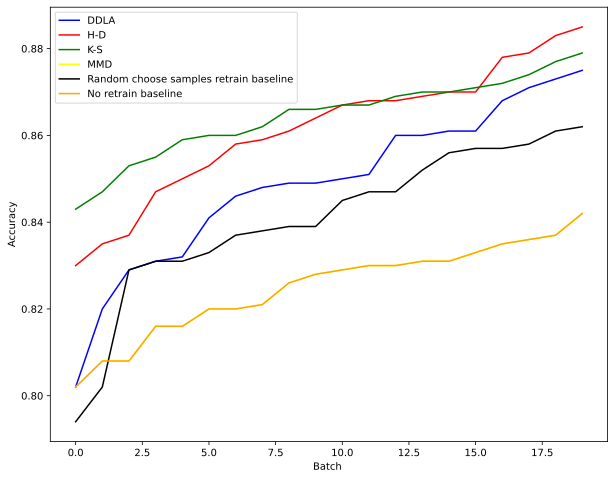

Average Oue methods: 0.8488499999999999
Average KS: 0.8643499999999997
Average MMD: 0.82495
Average HD: 0.8615499999999997
Average no retrain: 0.82495
Average ramdom choose retrain: 0.8407500000000001
The number our retrained accuracy highter than random: 12


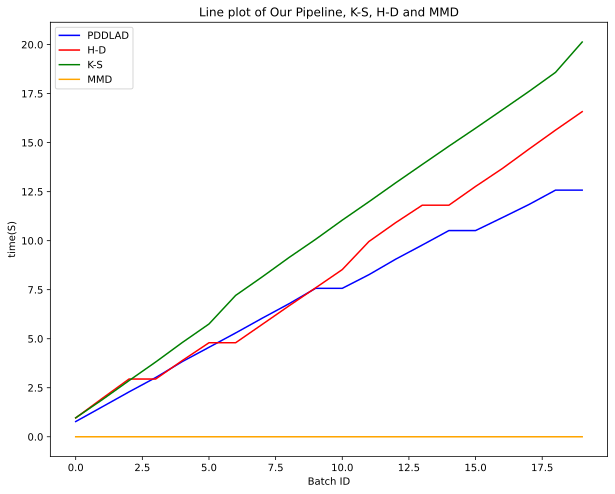

PDDLA retraining time: 12.577847003936768
KS retraining time: 20.12995433807373
MMD retraining time: 0
HD retraining time: 16.579193115234375
20


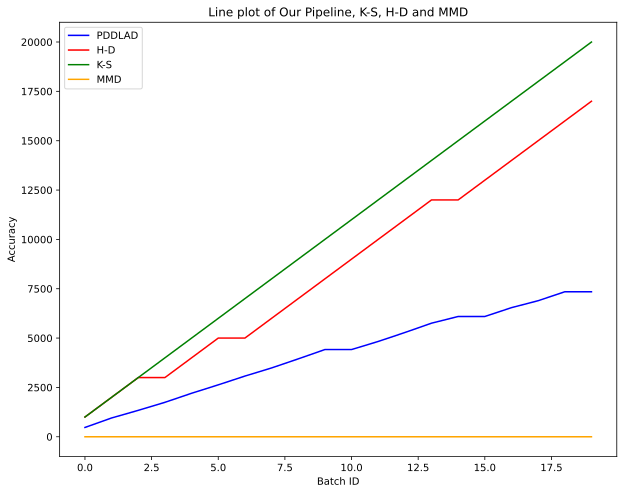

PDDLA the number that expert labeled: 7347
KS the number that expert labeled: 20000
HD the number that expert labeled: 17000
MMD the number that expert labeled: 0


In [19]:


print(f"our method choose low accuracy data's accuracy lower than sample acc {accuracy_sample_high_count} times")


print(f"DDLA retrain {PDDLA_Increase_count} times")
print(f'KS retrain {count_retrain_KS} times' )
print(f'MMD retrain {count_retrain_MMD} times' )
print(f'HD retrain {count_retrain_HD} times' )



###################
list4=accuracy_sample_list_MMD
list3=accuracy_sample_list_KS
list1=accuracy_sample_list_DDLA
list2=accuracy_sample_list_HD
list5=accuracy_sample_list_random
list7=accuracy_sample_list

##### Accuracy 
plt.figure(figsize=(10,8))
x_axis = list(range(len(list1)))

plt.plot(x_axis, np.sort(list1), color='blue', label='DDLA')
plt.plot(x_axis, np.sort(list2), color='red', label='H-D')
plt.plot(x_axis, np.sort(list3), color='green', label='K-S')
plt.plot(x_axis, np.sort(list4), color='yellow', label='MMD')
plt.plot(x_axis, np.sort(list5), color='black', label='Random choose samples retrain baseline')
plt.plot(x_axis, np.sort(list7), color='orange', label='No retrain baseline')


plt.legend()

plt.xlabel('Batch ')
plt.ylabel('Accuracy')
#plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

average_list1 = sum(list1) / len(list1)
print(f"Average Oue methods: {average_list1}")
average_list3 = sum(list3) / len(list3)
print(f"Average KS: {average_list3}")
average_list4 = sum(list4) / len(list4)
print(f"Average MMD: {average_list4}")
average_list2 = sum(list2) / len(list2)
print(f"Average HD: {average_list2}")
average_list7 = sum(list7) / len(list7)
print(f"Average no retrain: {average_list7}")
average_list5 = sum(list5) / len(list5)
print(f"Average ramdom choose retrain: {average_list5}")
count = sum(x > y for x, y in zip(list1, list5))
print(f"The number our retrained accuracy highter than random: {count}")



###########  retraining time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
x_axis = list(range(len(trainingtime_list_DDLA)))
# 对x进行累加
#print(len(Number_AL))
trainingtime_list_cumsum = np.cumsum(trainingtime_list_DDLA)
trainingtime_list_KS_cumsum = np.cumsum(trainingtime_list_KS)
trainingtime_list_MMD_cumsum = np.cumsum(trainingtime_list_MMD)
trainingtime_list_HD_cumsum = np.cumsum(trainingtime_list_HD)

plt.plot(x_axis, trainingtime_list_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, trainingtime_list_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, trainingtime_list_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, trainingtime_list_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('time(S)')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

print(f"PDDLA retraining time: {trainingtime_list_cumsum[-1]}")
print(f"KS retraining time: {trainingtime_list_KS_cumsum[-1]}")
print(f"MMD retraining time: {trainingtime_list_MMD_cumsum[-1]}")
print(f"HD retraining time: {trainingtime_list_HD_cumsum[-1]}")

########## expert label 


plt.figure(figsize=(10,8))
x_axis = list(range(len(Number_AL)))
# 对x进行累加
print(len(Number_AL))
Number_AL_cumsum = np.cumsum(Number_AL)
Number_AL_KS_cumsum = np.cumsum(Number_AL_KS)
Number_AL_MMD_cumsum = np.cumsum(Number_AL_MMD)
Number_AL_HD_cumsum = np.cumsum(Number_AL_HD)
# print(Number_AL_cumsum.shape)
# print(Number_AL_KS_cumsum)
plt.plot(x_axis, Number_AL_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, Number_AL_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, Number_AL_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, Number_AL_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()
print(f"PDDLA the number that expert labeled: {Number_AL_cumsum[-1]}")
print(f"KS the number that expert labeled: {Number_AL_KS_cumsum[-1]}")
print(f"HD the number that expert labeled: {Number_AL_HD_cumsum[-1]}")
print(f"MMD the number that expert labeled: {Number_AL_MMD_cumsum[-1]}")